# CELL 1: INSTALASI DAN IMPORT LIBRARY

In [12]:
!pip install nltk scikit-learn wordcloud gensim seaborn matplotlib tensorflow numpy pandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import string
import time
import joblib
from datetime import datetime

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

# Machine Learning & Deep Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

warnings.filterwarnings('ignore')
print("✅ Library berhasil diimport dan di-setup!")
print(f"✅ TensorFlow version: {tf.__version__}")

✅ Library berhasil diimport dan di-setup!
✅ TensorFlow version: 2.19.0


# CELL 2: MEMUAT DATASET

In [13]:
# --- PENTING ---
# Pastikan file CSV dari notebook scraping Anda sudah di-upload ke environment Colab.
# Ganti nama file di bawah ini jika berbeda.
DATASET_FILE = 'gps_reviews_dataset_20250904_034801.csv'

try:
    df = pd.read_csv(DATASET_FILE)
    print(f"✅ Dataset '{DATASET_FILE}' berhasil dimuat!")
    print(f"   - Jumlah data awal: {len(df):,} baris")
    print(f"   - Kolom: {list(df.columns)}")
except FileNotFoundError:
    print(f"❌ ERROR: File '{DATASET_FILE}' tidak ditemukan!")
    print("   - Harap upload file CSV hasil scraping Anda dan sesuaikan nama filenya.")
    df = pd.DataFrame() # Buat dataframe kosong agar tidak error di cell berikutnya

✅ Dataset 'gps_reviews_dataset_20250904_034801.csv' berhasil dimuat!
   - Jumlah data awal: 14,308 baris
   - Kolom: ['app_id', 'app_name', 'review_id', 'user_name', 'content', 'score', 'thumbs_up_count', 'at', 'sentiment']


# CELL 3: EKSPLORASI DATA AWAL (EDA)


🔍 ANALISIS EKSPLORASI DATA AWAL (EDA)


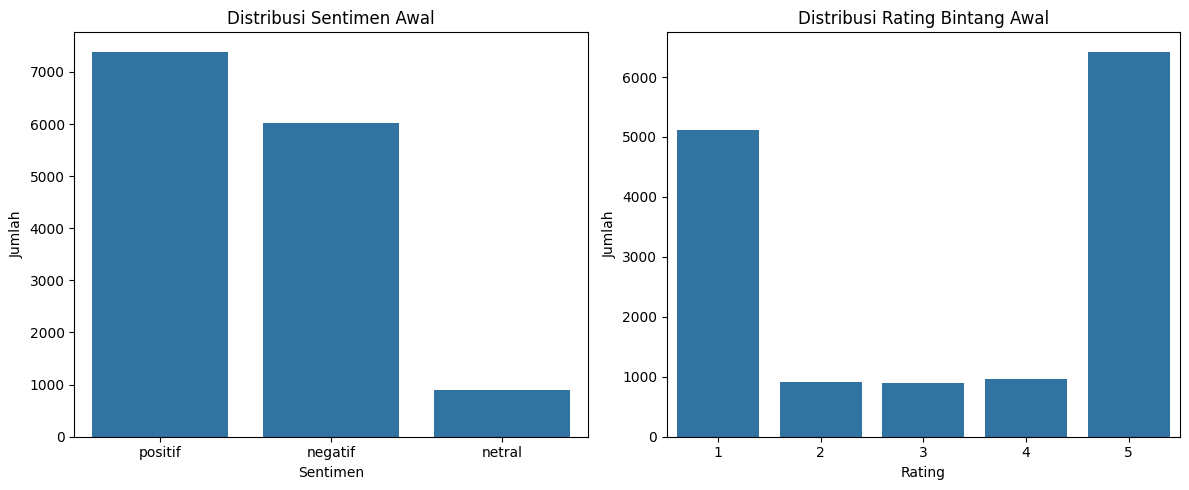

In [14]:
if not df.empty:
    print("\n🔍 ANALISIS EKSPLORASI DATA AWAL (EDA)")

    # Visualisasi Distribusi Sentimen Awal
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x='sentiment', data=df, order=['positif', 'negatif', 'netral'])
    plt.title('Distribusi Sentimen Awal')
    plt.xlabel('Sentimen')
    plt.ylabel('Jumlah')

    # Visualisasi Distribusi Rating
    plt.subplot(1, 2, 2)
    sns.countplot(x='score', data=df, order=[1, 2, 3, 4, 5])
    plt.title('Distribusi Rating Bintang Awal')
    plt.xlabel('Rating')
    plt.ylabel('Jumlah')
    plt.tight_layout()
    plt.show()


# CELL 4: TEXT PREPROCESSING

In [15]:
if not df.empty:
    print("\n🧹 PROSES PEMBERSIHAN TEKS (PREPROCESSING)")

    # Setup stopwords (Indonesian + English) - sama seperti di notebook Anda
    indonesian_stopwords = set(['yang', 'dan', 'di', 'ke', 'dari', 'dalam', 'untuk', 'pada', 'dengan', 'oleh', 'adalah', 'akan', 'telah', 'sudah', 'masih', 'dapat', 'bisa', 'harus', 'belum', 'ini', 'itu', 'tersebut', 'seperti', 'antara', 'karena', 'sehingga', 'tetapi', 'atau', 'jika', 'maka', 'agar', 'supaya', 'bahwa', 'dimana', 'ketika', 'saat', 'saya', 'anda', 'kamu', 'dia', 'mereka', 'kita', 'kami', 'kalian', 'tidak', 'bukan', 'jangan', 'tanpa', 'kecuali', 'selain', 'sangat', 'lebih', 'paling', 'cukup', 'agak', 'sedikit', 'banyak', 'app', 'aplikasi', 'google', 'play', 'store', 'android', 'ios'])
    english_stopwords = set(stopwords.words('english'))
    all_stopwords = indonesian_stopwords.union(english_stopwords)

    def advanced_preprocess(text):
        if pd.isna(text): return ""
        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'@\w+|#\w+', '', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', ' ', text) # Hapus tanda baca
        text = re.sub(r'\s+', ' ', text).strip()
        tokens = word_tokenize(text)
        filtered_tokens = [token for token in tokens if token.lower() not in all_stopwords and len(token) > 2]
        return ' '.join(filtered_tokens)

    # Terapkan preprocessing
    print("   - Menerapkan fungsi preprocessing pada kolom 'content'...")
    df['processed_content'] = df['content'].apply(advanced_preprocess)

    # Hapus baris yang kontennya kosong setelah diproses
    initial_len = len(df)
    df.dropna(subset=['processed_content'], inplace=True)
    df = df[df['processed_content'].str.len() > 5]
    final_len = len(df)

    print(f"   - Preprocessing selesai. Data tersisa: {final_len:,} (dihapus {initial_len - final_len:,})")
    print("\n   - Contoh hasil:")
    print(f"     Original : \"{df['content'].iloc[10]}\"")
    print(f"     Processed: \"{df['processed_content'].iloc[10]}\"")


🧹 PROSES PEMBERSIHAN TEKS (PREPROCESSING)
   - Menerapkan fungsi preprocessing pada kolom 'content'...
   - Preprocessing selesai. Data tersisa: 14,053 (dihapus 255)

   - Contoh hasil:
     Original : "oke banget"
     Processed: "oke banget"


# CELL 5: PENANGANAN CLASS IMBALANCE


⚖️ PENANGANAN CLASS IMBALANCE
   - Distribusi sebelum oversampling:
sentiment
positif    7216
negatif    5946
netral      891
Name: count, dtype: int64

   - Distribusi setelah oversampling:
sentiment
negatif    7216
positif    7216
netral     7216
Name: count, dtype: int64


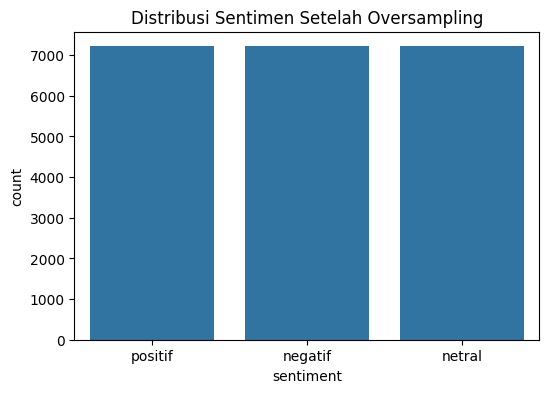

In [16]:
if not df.empty:
    print("\n⚖️ PENANGANAN CLASS IMBALANCE")

    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(df[['processed_content']], df['sentiment'])

    df_balanced = pd.DataFrame(X_resampled, columns=['processed_content'])
    df_balanced['sentiment'] = y_resampled

    print("   - Distribusi sebelum oversampling:")
    print(df['sentiment'].value_counts())
    print("\n   - Distribusi setelah oversampling:")
    print(df_balanced['sentiment'].value_counts())

    # Visualisasi setelah balancing
    plt.figure(figsize=(6, 4))
    sns.countplot(x='sentiment', data=df_balanced, order=['positif', 'negatif', 'netral'])
    plt.title('Distribusi Sentimen Setelah Oversampling')
    plt.show()

# CELL 6: FEATURE EXTRACTION (TOKENIZATION & PADDING)

In [17]:
if 'df_balanced' in locals():
    print("\n🔡 FEATURE EXTRACTION UNTUK DEEP LEARNING")

    # Pisahkan fitur dan label
    texts = df_balanced['processed_content'].values
    labels = df_balanced['sentiment'].values

    # Label Encoding
    encoder = LabelEncoder()
    labels_encoded = encoder.fit_transform(labels)

    # Tokenisasi
    vocab_size = 10000
    oov_tok = "<OOV>"
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
    tokenizer.fit_on_texts(texts)

    # Konversi teks ke sekuens angka
    sequences = tokenizer.texts_to_sequences(texts)

    # Padding
    max_length = 100 # Panjang maksimum sekuens
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

    print(f"   - Ukuran vocabulary: {len(tokenizer.word_index)}")
    print(f"   - Bentuk data padded: {padded_sequences.shape}")
    print(f"   - Bentuk data label: {labels_encoded.shape}")


🔡 FEATURE EXTRACTION UNTUK DEEP LEARNING
   - Ukuran vocabulary: 14361
   - Bentuk data padded: (21648, 100)
   - Bentuk data label: (21648,)


# CELL 7: DATA SPLITTING UNTUK MODEL


In [18]:
# ==================================================================================
# CELL 7 (PERBAIKAN): DATA SPLITTING (TRAIN, VALIDATION, TEST)
# ==================================================================================
if 'padded_sequences' in locals():
    print("\n✂️ PEMBAGIAN DATA MENJADI TRAIN, VALIDATION, & TEST SET")

    # Target: 80% Train, 10% Validation, 10% Test

    # Langkah 1: Pisahkan data menjadi 80% untuk data latih dan 20% untuk sementara (temp)
    X_train, X_temp, y_train, y_temp = train_test_split(
        padded_sequences,
        labels_encoded,
        test_size=0.2, # 20% dari data akan menjadi validation + test
        random_state=42,
        stratify=labels_encoded
    )

    # Langkah 2: Pisahkan data sementara (20%) menjadi 50% validation dan 50% test
    # Ini akan menghasilkan 10% validation dan 10% test dari total data asli
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp,
        y_temp,
        test_size=0.5, # 50% dari 20% adalah 10%
        random_state=42,
        stratify=y_temp
    )

    print(f"\nDistribusi Data:")
    print(f"   - Data Latih (Train)\t\t: {len(X_train)} sampel (~80%)")
    print(f"   - Data Validasi (Validation)\t: {len(X_val)} sampel (~10%)")
    print(f"   - Data Uji (Test)\t\t: {len(X_test)} sampel (~10%)")


✂️ PEMBAGIAN DATA MENJADI TRAIN, VALIDATION, & TEST SET

Distribusi Data:
   - Data Latih (Train)		: 17318 sampel (~80%)
   - Data Validasi (Validation)	: 2165 sampel (~10%)
   - Data Uji (Test)		: 2165 sampel (~10%)


# CELL 8: PEMBUATAN & PELATIHAN MODEL (3 SKEMA)

In [19]:
# ==================================================================================
# CELL 8 (PERBAIKAN): PEMBUATAN DAN PELATIHAN MODEL
# ==================================================================================
if 'X_train' in locals():
    print("\n🤖 PEMBUATAN DAN PELATIHAN MODEL DEEP LEARNING")

    # Konfigurasi umum
    embedding_dim = 64
    num_classes = len(encoder.classes_)

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

    histories = {}
    models = {} # Buat dictionary untuk menyimpan model yang sudah dilatih

    # --- SKEMA 1: Model LSTM yang Lebih Baik ---
    # <-- ARSITEKTUR DIPERBAIKI AGAR AKURASI TIDAK RENDAH
    print("\n--- [SKEMA 1] Melatih Model LSTM yang Lebih Baik ---")
    model_lstm = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        LSTM(64, return_sequences=True),
        GlobalMaxPooling1D(),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_lstm.summary()

    history_lstm = model_lstm.fit(
        X_train, y_train,
        epochs=15,
        batch_size=64,
        validation_data=(X_val, y_val), # <-- UBAH DI SINI (menggunakan data validasi)
        callbacks=[early_stopping, reduce_lr]
    )
    histories['LSTM'] = history_lstm
    models['LSTM'] = model_lstm

    # --- SKEMA 2: Model Bidirectional LSTM ---
    print("\n--- [SKEMA 2] Melatih Model Bidirectional LSTM ---")
    model_bilstm = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        Bidirectional(LSTM(64, return_sequences=True)),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model_bilstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_bilstm.summary()

    history_bilstm = model_bilstm.fit(
        X_train, y_train,
        epochs=15,
        batch_size=64,
        validation_data=(X_val, y_val), # <-- UBAH DI SINI (menggunakan data validasi)
        callbacks=[early_stopping, reduce_lr]
    )
    histories['BiLSTM'] = history_bilstm
    models['BiLSTM'] = model_bilstm

    # --- SKEMA 3: Model BiLSTM dengan Dropout lebih banyak ---
    print("\n--- [SKEMA 3] Melatih Model BiLSTM dengan Dropout lebih banyak ---")
    model_bilstm_v2 = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        Bidirectional(LSTM(128, return_sequences=True)),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.6),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model_bilstm_v2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_bilstm_v2.summary()

    history_bilstm_v2 = model_bilstm_v2.fit(
        X_train, y_train,
        epochs=15,
        batch_size=64,
        validation_data=(X_val, y_val), # <-- UBAH DI SINI (menggunakan data validasi)
        callbacks=[early_stopping, reduce_lr]
    )
    histories['BiLSTM_v2'] = history_bilstm_v2
    models['BiLSTM_v2'] = model_bilstm_v2


🤖 PEMBUATAN DAN PELATIHAN MODEL DEEP LEARNING

--- [SKEMA 1] Melatih Model LSTM yang Lebih Baik ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - accuracy: 0.4844 - loss: 0.9959 - val_accuracy: 0.7875 - val_loss: 0.6020 - learning_rate: 0.0010
Epoch 2/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.7996 - loss: 0.5587 - val_accuracy: 0.8263 - val_loss: 0.5094 - learning_rate: 0.0010
Epoch 3/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 41s 93ms/step - accuracy: 0.8577 - loss: 0.4361 - val_accuracy: 0.8550 - val_loss: 0.4168 - learning_rate: 0.0010
Epoch 4/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.8967 - loss: 0.3248 - val_accuracy: 0.8711 - val_loss: 0.3825 - learning_rate: 0.0010
Epoch 5/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 43s 97ms/step - accuracy: 0.9210 - loss: 0.2612 - val_accuracy: 0.8808 - val_loss: 0.3615 - learning_rate: 0.0010
Epoch 6/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 39s 91ms/step - accuracy: 0.9314 - loss: 0.2277 - val_accuracy: 0.8808 - val_loss: 0.3913 - learning_rate: 0.0010
Epoch 7/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.9368 - 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 52s 172ms/step - accuracy: 0.4909 - loss: 0.9847 - val_accuracy: 0.7746 - val_loss: 0.5940 - learning_rate: 0.0010
Epoch 2/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 88s 196ms/step - accuracy: 0.8014 - loss: 0.5342 - val_accuracy: 0.8443 - val_loss: 0.4430 - learning_rate: 0.0010
Epoch 3/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 52s 193ms/step - accuracy: 0.8856 - loss: 0.3385 - val_accuracy: 0.8721 - val_loss: 0.3541 - learning_rate: 0.0010
Epoch 4/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 53s 197ms/step - accuracy: 0.9098 - loss: 0.2661 - val_accuracy: 0.8841 - val_loss: 0.3468 - learning_rate: 0.0010
Epoch 5/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 73s 164ms/step - accuracy: 0.9250 - loss: 0.2125 - val_accuracy: 0.8841 - val_loss: 0.3614 - learning_rate: 0.0010
Epoch 6/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 81s 161ms/step - accuracy: 0.9400 - loss: 0.1849 - val_accuracy: 0.8873 - val_loss: 0.3764 - learning_rate: 0.0010
Epoch 7/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 45s 166ms/step - accuracy: 0.9

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 121s 427ms/step - accuracy: 0.4412 - loss: 1.0210 - val_accuracy: 0.6942 - val_loss: 0.7667 - learning_rate: 0.0010
Epoch 2/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 114s 419ms/step - accuracy: 0.7163 - loss: 0.6967 - val_accuracy: 0.8402 - val_loss: 0.4494 - learning_rate: 0.0010
Epoch 3/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 147s 438ms/step - accuracy: 0.8710 - loss: 0.3821 - val_accuracy: 0.8633 - val_loss: 0.3928 - learning_rate: 0.0010
Epoch 4/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 157s 494ms/step - accuracy: 0.9100 - loss: 0.2705 - val_accuracy: 0.8725 - val_loss: 0.3835 - learning_rate: 0.0010
Epoch 5/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 135s 467ms/step - accuracy: 0.9226 - loss: 0.2243 - val_accuracy: 0.8827 - val_loss: 0.3620 - learning_rate: 0.0010
Epoch 6/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 113s 418ms/step - accuracy: 0.9404 - loss: 0.1796 - val_accuracy: 0.8813 - val_loss: 0.4217 - learning_rate: 0.0010
Epoch 7/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 142s 416ms/step - accura

# CELL 9: EVALUASI MODEL


📈 EVALUASI PERFORMA MODEL

--- Hasil Akurasi pada Validation Set ---
  - Model LSTM:
    - Akurasi Training: 95.06%
    - Akurasi Validasi: 88.73%
  - Model BiLSTM:
    - Akurasi Training: 95.69%
    - Akurasi Validasi: 88.78%
  - Model BiLSTM_v2:
    - Akurasi Training: 96.12%
    - Akurasi Validasi: 89.05%

🏆 Model terbaik berdasarkan akurasi validasi adalah: BiLSTM_v2 (89.05%)

--- Grafik History untuk Model Terbaik (BiLSTM_v2) ---


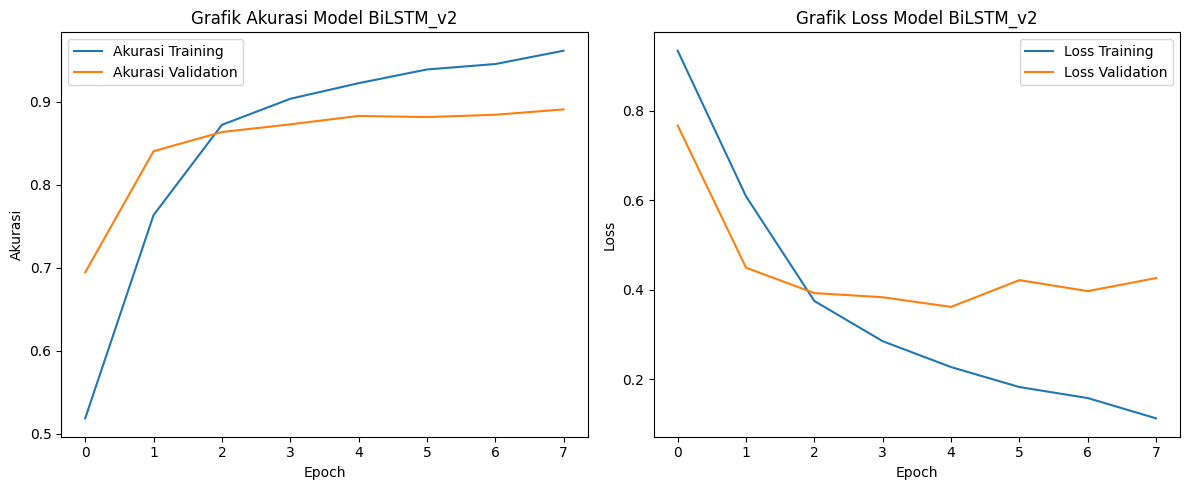


--- Evaluasi Akhir pada Test Set (Data Ujian Sebenarnya) ---

 Mengevaluasi Model: LSTM...
   - Test Loss    : 0.4087
   - Test Accuracy: 86.88%
   - ✅ Memenuhi kriteria > 85%

 Mengevaluasi Model: BiLSTM...
   - Test Loss    : 0.3853
   - Test Accuracy: 87.25%
   - ✅ Memenuhi kriteria > 85%

 Mengevaluasi Model: BiLSTM_v2...
   - Test Loss    : 0.3862
   - Test Accuracy: 87.07%
   - ✅ Memenuhi kriteria > 85%


In [20]:
# ==================================================================================
# CELL 9 (PERBAIKAN): EVALUASI MODEL PADA VALIDATION & TEST SET
# ==================================================================================
if 'histories' in locals():
    print("\n📈 EVALUASI PERFORMA MODEL")

    # --- Evaluasi pada Validation Set (Data Latihan Soal) ---
    print("\n--- Hasil Akurasi pada Validation Set ---")

    best_model_name = ''
    best_val_accuracy = 0

    results = {}

    for name, history in histories.items():
        val_acc = max(history.history['val_accuracy'])
        train_acc = max(history.history['accuracy'])
        results[name] = {'train_acc': train_acc, 'val_acc': val_acc}
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_model_name = name

    for name, accs in results.items():
        print(f"  - Model {name}:")
        print(f"    - Akurasi Training: {accs['train_acc']:.2%}")
        print(f"    - Akurasi Validasi: {accs['val_acc']:.2%}") # <-- Penamaan diperjelas

    print(f"\n🏆 Model terbaik berdasarkan akurasi validasi adalah: {best_model_name} ({best_val_accuracy:.2%})")
    best_model = models[best_model_name]

    # Plotting history model terbaik
    print(f"\n--- Grafik History untuk Model Terbaik ({best_model_name}) ---")
    best_history = histories[best_model_name]
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(best_history.history['accuracy'], label='Akurasi Training')
    plt.plot(best_history.history['val_accuracy'], label='Akurasi Validation')
    plt.title(f'Grafik Akurasi Model {best_model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Akurasi')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(best_history.history['loss'], label='Loss Training')
    plt.plot(best_history.history['val_loss'], label='Loss Validation')
    plt.title(f'Grafik Loss Model {best_model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # --- EVALUASI AKHIR PADA TEST SET (SESUAI FEEDBACK REVIEWER) ---
    print("\n" + "="*50)
    print("--- Evaluasi Akhir pada Test Set (Data Ujian Sebenarnya) ---")
    print("="*50)

    for name, model in models.items():
        print(f"\n Mengevaluasi Model: {name}...")
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f"   - Test Loss    : {loss:.4f}")
        print(f"   - Test Accuracy: {accuracy:.2%}")

        # Validasi Kriteria Dicoding pada TEST SET
        if accuracy > 0.92:
            print("   - ✅ Memenuhi kriteria > 92%")
        elif accuracy > 0.85:
            print("   - ✅ Memenuhi kriteria > 85%")
        else:
            print("   - ❌ Tidak memenuhi kriteria minimal 85%")

# CELL 10: INFERENCE (PENGUJIAN DENGAN TEKS BARU)

In [21]:
if 'best_model' in locals():
    print("\n🧪 INFERENCE - MENGUJI MODEL DENGAN KALIMAT BARU")

    def predict_sentiment(text):
        # Preprocessing teks input
        processed_text = advanced_preprocess(text)

        # Konversi ke sekuens
        sequence = tokenizer.texts_to_sequences([processed_text])

        # Padding
        padded = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

        # Prediksi
        prediction = best_model.predict(padded)
        predicted_class_index = np.argmax(prediction)

        # Konversi indeks ke label sentimen
        predicted_sentiment = encoder.inverse_transform([predicted_class_index])[0]

        return predicted_sentiment, prediction[0][predicted_class_index]

    # Contoh kalimat untuk diuji
    test_sentences = [
        "Aplikasi ini luar biasa, sangat membantu pekerjaan saya sehari-hari!",
        "Sering banget error dan keluar sendiri, tolong segera diperbaiki developernya.",
        "Lumayan sih, fiturnya cukup tapi kadang masih suka lemot.",
        "Keren, desainnya bagus dan mudah digunakan.",
        "Kecewa berat, setelah update malah jadi banyak bug."
    ]

    for sentence in test_sentences:
        sentiment, confidence = predict_sentiment(sentence)
        print(f"\nInput     : \"{sentence}\"")
        print(f"Prediksi  : {sentiment.upper()} (Confidence: {confidence:.2%})")


🧪 INFERENCE - MENGUJI MODEL DENGAN KALIMAT BARU
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step

Input     : "Aplikasi ini luar biasa, sangat membantu pekerjaan saya sehari-hari!"
Prediksi  : POSITIF (Confidence: 96.58%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

Input     : "Sering banget error dan keluar sendiri, tolong segera diperbaiki developernya."
Prediksi  : NETRAL (Confidence: 99.77%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

Input     : "Lumayan sih, fiturnya cukup tapi kadang masih suka lemot."
Prediksi  : POSITIF (Confidence: 46.10%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

Input     : "Keren, desainnya bagus dan mudah digunakan."
Prediksi  : POSITIF (Confidence: 97.69%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Input     : "Kecewa berat, setelah update malah jadi banyak bug."
Prediksi  : NEGATIF (Confidence: 88.62%)


In [22]:
!pip freeze > requirements.txt